# Projet MADMC

In [121]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import NDTree

In [122]:
def readInstance(path):

    with open(path, 'r') as f:
        allLines = f.readlines()

    n = int(allLines[2].split(" ")[1])

    objects = np.empty((n, 3))
    for i, line in enumerate(allLines[4:4+n]):
        objects[i] = list( map(int, line.rstrip().lstrip("i ").split("\t")) )

    W = int(allLines[-2].split(" ")[1])

    return objects, W

In [123]:
def readNotDominatedPoints(path):

    with open(path, 'r') as f:
        allLines = f.readlines()

    allPoints = []
    for line in allLines:
        allPoints.append( list(map(int, line.rstrip().split("\t"))) )

    return np.array(allPoints)

In [124]:
def proportionNotDominated(nd_points, potential_nd_points):
    nd_points_set = set(list(map(tuple, nd_points)))
    potential_nd_points_set = set(list(map(tuple, potential_nd_points)))
    
    return len(nd_points_set & potential_nd_points_set)/len(nd_points)

In [125]:
def averageDistance(nd_points, potential_nd_points):
    nadir_pt = np.array((nd_points[:, 0].min(), nd_points[:, 1].min()))
    print(nadir_pt)
    ideal_pt = np.array((nd_points[:, 0].max(), nd_points[:, 1].max()))
    p1 = 1/(ideal_pt[0]-nadir_pt[0])
    p2 = 1/(ideal_pt[1]-nadir_pt[1])
    
    distances = []
    
    for i, nd_point in enumerate(nd_points):
        euclidian_dist = math.inf
        for potential_nd_point in potential_nd_points:
            euclidian_dist_tmp =  math.sqrt(p1*(potential_nd_point[0]-nd_point[0])**2 + p2*(potential_nd_point[1]-nd_point[1])**2)
            
            if(euclidian_dist_tmp < euclidian_dist):
                euclidian_dist = euclidian_dist_tmp
    
        distances.append(euclidian_dist)
    
    distances = np.array(distances)
    
    return (1/len(nd_points))*distances.sum()


In [126]:
def solutionTotalWeight(solution, objects):
    sum = 0
    for i, sol in enumerate(solution):
        if(sol == 1):
            sum += objects[:,0][i]
    return sum

In [127]:
def generatePop(objects, max_weight):
    solution = np.random.randint(2, size=len(objects))
    sumWeights = 0
    freeObjectsIndexes = []
    
    for i in range(0, len(solution)):
        if(solution[i] == 1):
            sumWeights += objects[:,0][i]
        else:
            freeObjectsIndexes.append(i)

        #make sure that the solution respects max weight
        if(sumWeights > max_weight):
            solution[i] = 0
            sumWeights -= objects[:,0][i]
            freeObjectsIndexes.append(i)
    
    #add random objects to fill the bag
    while(sumWeights < max_weight and len(freeObjectsIndexes) > 0):
        i = random.randint(0, len(freeObjectsIndexes)-1)
        if(sumWeights + objects[:,0][freeObjectsIndexes[i]] < max_weight):
            solution[freeObjectsIndexes[i]] = 1
            sumWeights += objects[:,0][freeObjectsIndexes[i]]
            #print("add ", objects[:,0][freeObjectsIndexes[i]], sumWeights)
        del freeObjectsIndexes[i]
            
    #print("current weight : ", sumWeights, " max weight : ", max_weight)
    
    
    return solution

In [128]:
def neighborhood(solution, objects, max_weight):
    solutionSum = solution.sum()
    neighborhoodPop = []
    
    #if there is at least one object selected and still some other(s) not selected
    if(solutionSum >= 1 and solutionSum < len(objects)):
        totalWeight = solutionTotalWeight(solution, objects)
        newTotalWeight = totalWeight
        neighbor_sol = solution.copy()
        permutationDone = False
        
        #sort objects in two lists (of indexes) wether they are in backpack or not
        availableObjects = []
        takenObjects = []
        for i in range(0, len(neighbor_sol)-1):
            if(neighbor_sol[i] == 0):
                availableObjects.append(i)
            else:
                takenObjects.append(i)
                
        for i in range(len(takenObjects)):
            takenObjectIndex = takenObjects[i]

            for j in range(len(availableObjects)):
                availableObjectIndex = availableObjects[j]

                newTotalWeight = totalWeight - objects[:,0][takenObjectIndex] + objects[:,0][availableObjectIndex]

                #permutation only if valid solution
                if(newTotalWeight > max_weight):
                    break
                else:
                    neighbor_sol = solution.copy()
                    totalWeight = newTotalWeight
                    permutationDone = True
                    neighbor_sol[takenObjectIndex] = 0
                    neighbor_sol[availableObjectIndex] = 1
                    
                    availableObjectsTmp = availableObjects.copy()
                    availableObjectsTmp.append(availableObjectIndex)
                    del availableObjectsTmp[j] #no need to del for takenObjects (list not used after)
                    #print("replaced index", takenObjectIndex, "with", availableObjectIndex)


                    #new spaces filled with objects if possible
                    new_object_index = random.randint(0, len(availableObjectsTmp)-1)
                    availableObjectIndex = availableObjectsTmp[new_object_index]

                    while(totalWeight < max_weight and len(availableObjectsTmp) > 0):
                        if(totalWeight+objects[:,0][availableObjectIndex] <= max_weight):
                            neighbor_sol[availableObjectIndex] = 1
                            totalWeight += objects[:,0][availableObjectIndex]

                        del availableObjectsTmp[new_object_index]

                        if(len(availableObjectsTmp) > 0): #verification for the last loop
                            new_object_index = random.randint(0, len(availableObjectsTmp)-1)
                            availableObjectIndex = availableObjectsTmp[new_object_index]
                    
                    neighborhoodPop.append(neighbor_sol)
                    
        #print("aa",neighborhoodPop,"bb", neighborhoodPop[0])
        return neighborhoodPop

In [129]:
def evaluateSolution(solution, earnings):
    earnings_values = [0]*(earnings[0].size)
    
    for i in range(earnings[0].size): #for each objective
        for j in range(earnings[:, i].size-1): #the valuation for each object
            earnings_values[i] += solution[j]*earnings[:, i][j] #solution[j] = 1 or 0
    return earnings_values

In [130]:
def evaluate_solution(solution, objects, capacity, with_capacity=False):
    evaluation = np.matmul(solution.T, objects)

    # retourne solution + sa validité
    if with_capacity:
        return evaluation[0] <= capacity, evaluation
    else:
        return evaluation[0] <= capacity, evaluation[1:]



In [131]:
def isDominated(sol1, sol2, earnings):
    earnings_sol1 = evaluateSolution(sol1, earnings)
    earnings_sol2 = evaluateSolution(sol2, earnings)
    if earnings_sol1[0] < earnings_sol2[0]:
        return earnings_sol1[1] <= earnings_sol2[1]
    return False

In [132]:
def update(solutionsSet, solutionToReview, objects, earnings):

    update = True
    for solution in reversed(solutionsSet):
        if(isDominated(solutionToReview, solution, earnings)):
            update = False
            break
        #if(isDominated(solution, solutionToReview, earnings)):#si la nouvelle solution domine un point
            #solutionsSet.remove(solution)
        #print(solution)

    #remove the dominated points by the new solution
    if update:
        solutionsSet.append(np.array(solutionToReview))
    return update

In [133]:
def arraytoString(array):
    return ''.join(array)


In [134]:
def plot_objective_space(points, points2):
    x, y = [i[0] for i in points], [j[1] for j in points]
    x2, y2 = [int(i[0]) for i in points2], [int(j[1]) for j in points2]
    plt.scatter(x, y, c='red')
    plt.scatter(x2, y2, c='blue')
    plt.show()

In [135]:
def localParetoSearch1(objects, capacity, non_dominated_points=[]):
    earnings = objects[:, 1:]

    #objects = objects[objects[:, 0].argsort()]

    #random_sol, solution_alea = generatePop(objects, capacity)
    random_sol = generatePop(objects, capacity)

    #valid, evalP = evaluateSolution(solution_alea, objects, capacity)
    evalP = evaluateSolution(random_sol, objects, capacity)
    
    # initialisation d'un ens. de sol. efficaces  et d'une population
    population = []
    efficient_solutions = []
    efficient_solutions.append(random_sol)
    population.append(np.array(random_sol))
    k = 0
    ez = [evalP]
    # initialisation d'une pop. auxiliaire
    auxiliar_population = []
    evalBase = []
    while(len(population) > 0):
        k += 1
        j = 0

        #print(population)
        # génération de tous les voisins de chaque solution appartenant à population
        nghbhood, evals = [], []
        for p in population:
            print(str((j)/len(population)*100) + '%')

            j += 1

            valid, evalBase = evaluate_solution(p, objects, capacity)
            #evalBase = evaluateSolution(p, earnings)


            #voisinage, evals = voisinage1_1(p, objects, capacity)
            nghbhood = neighborhood(p, objects, capacity)
            
            #while not voisinage:
            #voisinage, evals = voisinage1_1(p, objects, capacity)

            #for voisin, eval in zip(voisinage, evals):
            for neighbor in nghbhood:
                #print('nouvelleeval')
                #print(eval)
                # si p_prime n'est pas dominé par p:

                #if not dominated(eval, evalBase):
                if not Dominates(neighbor, p):

                    if update(auxiliar_population, neighbor, objects, earnings):
                        update(efficient_solutions, neighbor, objects, earnings)
                        
            nghbhood, evals = [], []
            
            
        if len(efficient_solutions) > 10:
            ez = [evaluateSolution(r, earnings) for r in efficient_solutions]
            print(ez)
            plot_objective_space(ez, non_dominated_points)

        population = auxiliar_population
        auxiliar_population = []
        #print('efficient solutions=Evaluations')
        print('taille du front efficace')
        print(np.array(efficient_solutions).shape)

    return efficient_solutions


In [147]:
def localParetoSearchNew(objects, capacity, non_dominated_points = []):
    earnings = objects[:, 1:]
    weights = objects[:, 0]
    nbDims = 2
    #NDTree.NDTree(nbDims)
    #objects = objects[objects[:, 0].argsort()]

    #random_sol, solution_alea = generatePop(objects, capacity)
    random_sol = generatePop(objects, capacity)

    #valid, evalP = evaluateSolution(solution_alea, objects, capacity)
    valid,evalP = evaluate_solution(random_sol,objects, capacity)
    
    # initialisation d'un ens. de sol. efficaces  et d'une population
    population = []
    efficient_solutions = []
    efficient_solutions.append(random_sol)
    population.append(random_sol)
    k = 0
    ez = []
    ez.append(evalP)
    # initialisation d'une pop. auxiliaire
    auxiliar_population = []
    evalBase = []
    while(len(population) > 0):
        k += 1
        j = 0

        #print(population)
        # génération de tous les voisins de chaque solution appartenant à population
        nghbhood, evals = [], []
        for p in population:
            print(str((j)/len(population)*100) + '%')

            j += 1

            #valid, evalBase = evaluate_solution(p, objects, capacity)
            valid2 ,evalBase = evaluate_solution(p,objects, capacity)


            #voisinage, evals = voisinage1_1(p, objects, capacity)
            nghbhood = neighborhood(p, objects, capacity)
            
            #while not voisinage:
            #voisinage, evals = voisinage1_1(p, objects, capacity)

            #for voisin, eval in zip(voisinage, evals):
            for neighbor in nghbhood:
                
                #print('nouvelleeval')
                #print(eval)
                # si p_prime n'est pas dominé par p:
                valid3, evalNeighbor = evaluate_solution(neighbor,objects, capacity)
                #if not dominated(eval, evalBase):
                if not Dominates(evalBase, evalNeighbor) and valid3 and valid2:
                    candidate = {repr(neighbor): np.array(evalBase)}

                    if update(auxiliar_population, neighbor, objects, earnings):
                        update(efficient_solutions, neighbor, objects, earnings)
                        
            nghbhood, evals = [], []
            
            
        if len(efficient_solutions) > 10:
            ez = [evaluate_solution(r, objects,capacity)[1] for r in efficient_solutions]
            
            print(ez)


            plot_objective_space(ez, non_dominated_points)

        population = auxiliar_population
        auxiliar_population = []
        #print('efficient solutions=Evaluations')
        print('taille du front efficace')
        print(np.array(efficient_solutions).shape)

    return efficient_solutions


In [137]:
a = []
b = np.array([4,5,6])
a.append(b)
a.remove(b)
print(a)

[]


**-------------TEST METHODES-------------**

In [150]:
(objects, weight) = readInstance("100_items/2KP100-TA-0.dat")
nd_points = readNotDominatedPoints("100_items/2KP100-TA-0.eff")
print(objects, "\n max weight :", weight)

[[394. 783. 840.]
 [911. 198. 798.]
 [768. 278. 335.]
 [477. 629. 554.]
 [513. 952. 365.]
 [636. 717. 916.]
 [607.  17. 142.]
 [138. 804. 243.]
 [401. 130. 157.]
 [998. 219. 109.]
 [839. 613. 513.]
 [637. 524. 296.]
 [972. 293. 494.]
 [527. 770. 771.]
 [891. 284. 400.]
 [807. 919. 353.]
 [949. 526.  70.]
 [193. 663.  86.]
 [349.  65. 890.]
 [458.  64.  21.]
 [970. 902. 239.]
 [267. 540. 851.]
 [760. 513. 375.]
 [532.  40. 668.]
 [931. 930. 438.]
 [285. 738. 721.]
 [354. 688. 640.]
 [440. 880. 166.]
 [331. 229. 829.]
 [351. 686. 893.]
 [589. 657. 956.]
 [440. 924. 858.]
 [814. 684. 399.]
 [483. 216. 911.]
 [920. 148. 950.]
 [641. 432. 881.]
 [281. 786. 619.]
 [447. 226. 308.]
 [276. 556. 188.]
 [170. 906. 417.]
 [126. 495. 104.]
 [984. 935. 760.]
 [383. 750. 684.]
 [294. 233. 369.]
 [245. 153. 584.]
 [126. 793. 732.]
 [745.  75. 164.]
 [ 53. 522. 950.]
 [240. 798. 177.]
 [656. 967. 732.]
 [759.  94. 639.]
 [520.  79. 135.]
 [205. 461.  70.]
 [573. 755. 819.]
 [158. 999.  52.]
 [890. 126

In [139]:
#earnings for each objective
earnings = objects[:,1:]
print(earnings[:, 1].size-1)
print(earnings)

99
[[783. 840.]
 [198. 798.]
 [278. 335.]
 [629. 554.]
 [952. 365.]
 [717. 916.]
 [ 17. 142.]
 [804. 243.]
 [130. 157.]
 [219. 109.]
 [613. 513.]
 [524. 296.]
 [293. 494.]
 [770. 771.]
 [284. 400.]
 [919. 353.]
 [526.  70.]
 [663.  86.]
 [ 65. 890.]
 [ 64.  21.]
 [902. 239.]
 [540. 851.]
 [513. 375.]
 [ 40. 668.]
 [930. 438.]
 [738. 721.]
 [688. 640.]
 [880. 166.]
 [229. 829.]
 [686. 893.]
 [657. 956.]
 [924. 858.]
 [684. 399.]
 [216. 911.]
 [148. 950.]
 [432. 881.]
 [786. 619.]
 [226. 308.]
 [556. 188.]
 [906. 417.]
 [495. 104.]
 [935. 760.]
 [750. 684.]
 [233. 369.]
 [153. 584.]
 [793. 732.]
 [ 75. 164.]
 [522. 950.]
 [798. 177.]
 [967. 732.]
 [ 94. 639.]
 [ 79. 135.]
 [461.  70.]
 [755. 819.]
 [999.  52.]
 [126. 205.]
 [870. 997.]
 [923.  73.]
 [163. 594.]
 [819. 392.]
 [579. 359.]
 [100. 453.]
 [304. 531.]
 [877. 992.]
 [ 36. 748.]
 [925. 748.]
 [979. 873.]
 [983. 744.]
 [164. 667.]
 [ 77. 830.]
 [629. 650.]
 [317. 229.]
 [ 75. 329.]
 [651. 633.]
 [280. 511.]
 [114. 546.]
 [944. 47

In [146]:
#print(nd_points)
nd_points = np.hsplit(nd_points, 2)
#print(nd_points)
#plot.plot(nd_points[:,0], nd_points[:,1])

In [141]:
generatedPop = generatePop(objects, weight)
print(generatedPop, solutionTotalWeight(generatedPop, objects), len(neighborhood(generatedPop, objects, weight)))

[0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0
 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0
 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1] 26802.0 205


In [142]:
evaluateSolution(generatedPop, earnings)

[25366.0, 27665.0]

In [143]:
neighbor = neighborhood(generatedPop, objects, weight)
print(neighbor, solutionTotalWeight(neighbor, objects))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
localParetoSearch1(objects, weight, nd_points)

In [144]:

def Dominates(point, candidate):
    return sum([point[x] >= candidate[x] for x in range(len(point))]) == len(point) 

0.0%
taille du front efficace
(8, 100)
0.0%
14.285714285714285%
28.57142857142857%
42.857142857142854%
57.14285714285714%
71.42857142857143%
85.71428571428571%
[array([26474., 26939.]), array([26059., 27224.]), array([27134., 27530.]), array([27172., 27975.]), array([27745., 27812.]), array([28576., 28594.]), array([28568., 29154.]), array([29297., 29253.]), array([26707., 29611.]), array([27678., 29507.]), array([28717., 29282.]), array([29274., 29428.]), array([29381., 28756.]), array([30339., 30159.]), array([29627., 30821.]), array([30384., 30866.]), array([30476., 30906.]), array([29919., 31156.]), array([31159., 29776.]), array([30751., 30495.])]


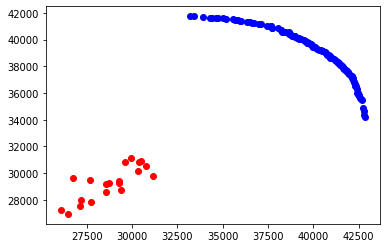

taille du front efficace
(20, 100)
0.0%
4.3478260869565215%
8.695652173913043%
13.043478260869565%
17.391304347826086%
21.73913043478261%
26.08695652173913%
30.434782608695656%
34.78260869565217%
39.130434782608695%
43.47826086956522%
47.82608695652174%
52.17391304347826%
56.52173913043478%
60.86956521739131%
65.21739130434783%
69.56521739130434%
73.91304347826086%
78.26086956521739%
82.6086956521739%
86.95652173913044%
91.30434782608695%
95.65217391304348%
[array([26474., 26939.]), array([26059., 27224.]), array([27134., 27530.]), array([27172., 27975.]), array([27745., 27812.]), array([28576., 28594.]), array([28568., 29154.]), array([29297., 29253.]), array([26707., 29611.]), array([27678., 29507.]), array([28717., 29282.]), array([29274., 29428.]), array([29381., 28756.]), array([30339., 30159.]), array([29627., 30821.]), array([30384., 30866.]), array([30476., 30906.]), array([29919., 31156.]), array([31159., 29776.]), array([30751., 30495.]), array([30342., 31330.]), array([30464

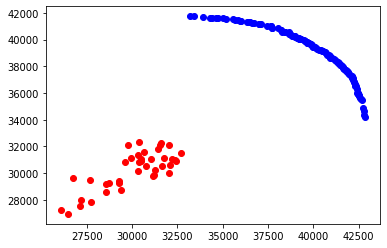

taille du front efficace
(40, 100)
0.0%
2.941176470588235%
5.88235294117647%
8.823529411764707%
11.76470588235294%
14.705882352941178%
17.647058823529413%
20.588235294117645%
23.52941176470588%
26.47058823529412%
29.411764705882355%
32.35294117647059%
35.294117647058826%
38.23529411764706%
41.17647058823529%
44.11764705882353%
47.05882352941176%
50.0%
52.94117647058824%
55.88235294117647%
58.82352941176471%
61.76470588235294%
64.70588235294117%
67.64705882352942%
70.58823529411765%
73.52941176470588%
76.47058823529412%
79.41176470588235%
82.35294117647058%
85.29411764705883%
88.23529411764706%
91.17647058823529%
94.11764705882352%
97.05882352941177%
[array([26474., 26939.]), array([26059., 27224.]), array([27134., 27530.]), array([27172., 27975.]), array([27745., 27812.]), array([28576., 28594.]), array([28568., 29154.]), array([29297., 29253.]), array([26707., 29611.]), array([27678., 29507.]), array([28717., 29282.]), array([29274., 29428.]), array([29381., 28756.]), array([30339., 3

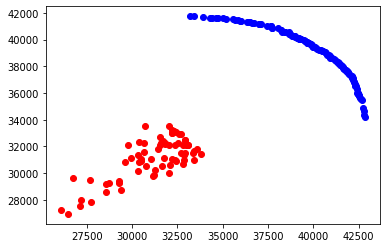

taille du front efficace
(71, 100)
0.0%
1.694915254237288%
3.389830508474576%
5.084745762711865%
6.779661016949152%
8.47457627118644%
10.16949152542373%
11.864406779661017%
13.559322033898304%
15.254237288135593%
16.94915254237288%
18.64406779661017%
20.33898305084746%
22.033898305084744%
23.728813559322035%
25.423728813559322%
27.11864406779661%
28.8135593220339%
30.508474576271187%
32.20338983050847%
33.89830508474576%
35.59322033898305%
37.28813559322034%
38.983050847457626%
40.67796610169492%
42.3728813559322%
44.06779661016949%
45.76271186440678%
47.45762711864407%
49.152542372881356%
50.847457627118644%
52.54237288135594%
54.23728813559322%
55.932203389830505%
57.6271186440678%
59.32203389830508%
61.016949152542374%
62.71186440677966%
64.40677966101694%
66.10169491525424%
67.79661016949152%
69.49152542372882%
71.1864406779661%
72.88135593220339%
74.57627118644068%
76.27118644067797%
77.96610169491525%
79.66101694915254%
81.35593220338984%
83.05084745762711%
84.7457627118644%
86.4

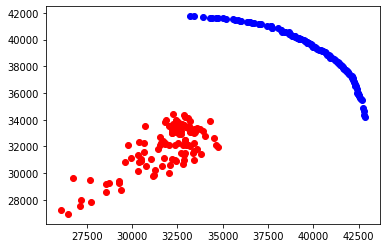

taille du front efficace
(110, 100)
0.0%
0.9523809523809524%
1.9047619047619049%
2.857142857142857%
3.8095238095238098%
4.761904761904762%
5.714285714285714%
6.666666666666667%
7.6190476190476195%
8.571428571428571%
9.523809523809524%
10.476190476190476%
11.428571428571429%
12.380952380952381%
13.333333333333334%
14.285714285714285%
15.238095238095239%
16.19047619047619%
17.142857142857142%
18.095238095238095%
19.047619047619047%
20.0%
20.952380952380953%
21.904761904761905%
22.857142857142858%
23.809523809523807%
24.761904761904763%
25.71428571428571%
26.666666666666668%
27.61904761904762%
28.57142857142857%
29.523809523809526%
30.476190476190478%
31.428571428571427%
32.38095238095238%
33.33333333333333%
34.285714285714285%
35.23809523809524%
36.19047619047619%
37.142857142857146%
38.095238095238095%
39.04761904761905%
40.0%
40.95238095238095%
41.904761904761905%
42.857142857142854%
43.80952380952381%
44.761904761904766%
45.714285714285715%
46.666666666666664%
47.61904761904761%
48.57

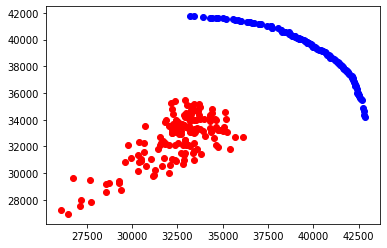

taille du front efficace
(152, 100)
0.0%
0.819672131147541%
1.639344262295082%
2.459016393442623%
3.278688524590164%
4.098360655737705%
4.918032786885246%
5.737704918032787%
6.557377049180328%
7.377049180327869%
8.19672131147541%
9.01639344262295%
9.836065573770492%
10.655737704918032%
11.475409836065573%
12.295081967213115%
13.114754098360656%
13.934426229508196%
14.754098360655737%
15.573770491803279%
16.39344262295082%
17.21311475409836%
18.0327868852459%
18.852459016393443%
19.672131147540984%
20.491803278688526%
21.311475409836063%
22.131147540983605%
22.950819672131146%
23.770491803278688%
24.59016393442623%
25.40983606557377%
26.229508196721312%
27.049180327868854%
27.86885245901639%
28.688524590163933%
29.508196721311474%
30.327868852459016%
31.147540983606557%
31.967213114754102%
32.78688524590164%
33.60655737704918%
34.42622950819672%
35.24590163934426%
36.0655737704918%
36.885245901639344%
37.704918032786885%
38.52459016393443%
39.34426229508197%
40.16393442622951%
40.983606

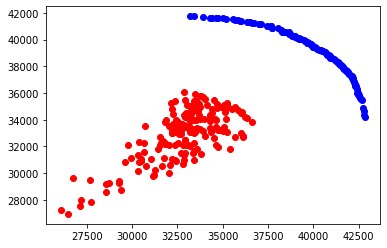

taille du front efficace
(181, 100)
0.0%
0.6756756756756757%
1.3513513513513513%
2.027027027027027%
2.7027027027027026%
3.3783783783783785%
4.054054054054054%
4.72972972972973%
5.405405405405405%
6.081081081081082%
6.756756756756757%
7.4324324324324325%
8.108108108108109%
8.783783783783784%
9.45945945945946%
10.135135135135135%
10.81081081081081%
11.486486486486488%
12.162162162162163%
12.837837837837837%
13.513513513513514%
14.18918918918919%
14.864864864864865%
15.54054054054054%
16.216216216216218%
16.89189189189189%
17.56756756756757%
18.243243243243242%
18.91891891891892%
19.594594594594593%
20.27027027027027%
20.945945945945947%
21.62162162162162%
22.2972972972973%
22.972972972972975%
23.64864864864865%
24.324324324324326%
25.0%
25.675675675675674%
26.351351351351347%
27.027027027027028%
27.7027027027027%
28.37837837837838%
29.054054054054053%
29.72972972972973%
30.405405405405407%
31.08108108108108%
31.756756756756754%
32.432432432432435%
33.108108108108105%
33.78378378378378%
3

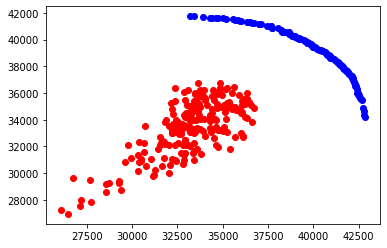

taille du front efficace
(221, 100)
0.0%
0.6493506493506493%
1.2987012987012987%
1.948051948051948%
2.5974025974025974%
3.2467532467532463%
3.896103896103896%
4.545454545454546%
5.194805194805195%
5.844155844155844%
6.493506493506493%
7.142857142857142%
7.792207792207792%
8.441558441558442%
9.090909090909092%
9.740259740259742%
10.38961038961039%
11.03896103896104%
11.688311688311687%
12.337662337662337%
12.987012987012985%
13.636363636363635%
14.285714285714285%
14.935064935064934%
15.584415584415584%
16.233766233766232%
16.883116883116884%
17.532467532467532%
18.181818181818183%
18.83116883116883%
19.480519480519483%
20.12987012987013%
20.77922077922078%
21.428571428571427%
22.07792207792208%
22.727272727272727%
23.376623376623375%
24.025974025974026%
24.675324675324674%
25.324675324675322%
25.97402597402597%
26.623376623376622%
27.27272727272727%
27.92207792207792%
28.57142857142857%
29.22077922077922%
29.87012987012987%
30.519480519480517%
31.16883116883117%
31.818181818181817%
32.

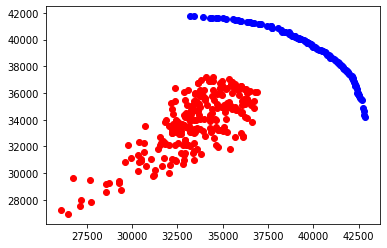

taille du front efficace
(249, 100)
0.0%
0.6024096385542169%
1.2048192771084338%
1.8072289156626504%
2.4096385542168677%
3.0120481927710845%
3.614457831325301%
4.216867469879518%
4.819277108433735%
5.421686746987952%
6.024096385542169%
6.626506024096386%
7.228915662650602%
7.83132530120482%
8.433734939759036%
9.036144578313253%
9.63855421686747%
10.240963855421686%
10.843373493975903%
11.44578313253012%
12.048192771084338%
12.650602409638553%
13.253012048192772%
13.855421686746988%
14.457831325301203%
15.060240963855422%
15.66265060240964%
16.265060240963855%
16.867469879518072%
17.46987951807229%
18.072289156626507%
18.67469879518072%
19.27710843373494%
19.879518072289155%
20.481927710843372%
21.084337349397593%
21.686746987951807%
22.289156626506024%
22.89156626506024%
23.49397590361446%
24.096385542168676%
24.69879518072289%
25.301204819277107%
25.903614457831324%
26.506024096385545%
27.10843373493976%
27.710843373493976%
28.313253012048197%
28.915662650602407%
29.518072289156628%
3

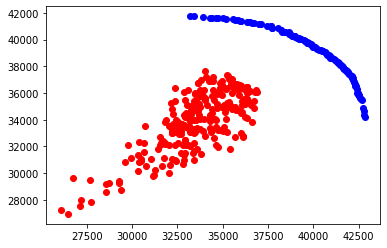

taille du front efficace
(261, 100)
0.0%
0.6134969325153374%
1.2269938650306749%
1.8404907975460123%
2.4539877300613497%
3.067484662576687%
3.6809815950920246%
4.294478527607362%
4.9079754601226995%
5.521472392638037%
6.134969325153374%
6.748466257668712%
7.361963190184049%
7.975460122699387%
8.588957055214724%
9.202453987730062%
9.815950920245399%
10.429447852760736%
11.042944785276074%
11.65644171779141%
12.269938650306749%
12.883435582822086%
13.496932515337424%
14.11042944785276%
14.723926380368098%
15.337423312883436%
15.950920245398773%
16.56441717791411%
17.177914110429448%
17.791411042944784%
18.404907975460123%
19.018404907975462%
19.631901840490798%
20.245398773006134%
20.858895705521473%
21.472392638036812%
22.085889570552148%
22.699386503067483%
23.31288343558282%
23.92638036809816%
24.539877300613497%
25.153374233128833%
25.766871165644172%
26.380368098159508%
26.993865030674847%
27.607361963190186%
28.22085889570552%
28.834355828220858%
29.447852760736197%
30.061349693251

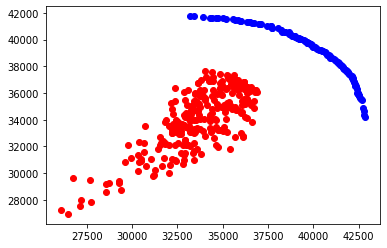

taille du front efficace
(278, 100)
0.0%
0.6097560975609756%
1.2195121951219512%
1.8292682926829267%
2.4390243902439024%
3.048780487804878%
3.6585365853658534%
4.2682926829268295%
4.878048780487805%
5.487804878048781%
6.097560975609756%
6.707317073170732%
7.317073170731707%
7.926829268292683%
8.536585365853659%
9.146341463414634%
9.75609756097561%
10.365853658536585%
10.975609756097562%
11.585365853658537%
12.195121951219512%
12.804878048780488%
13.414634146341465%
14.02439024390244%
14.634146341463413%
15.24390243902439%
15.853658536585366%
16.463414634146343%
17.073170731707318%
17.682926829268293%
18.29268292682927%
18.902439024390244%
19.51219512195122%
20.121951219512198%
20.73170731707317%
21.341463414634145%
21.951219512195124%
22.5609756097561%
23.170731707317074%
23.78048780487805%
24.390243902439025%
25.0%
25.609756097560975%
26.21951219512195%
26.82926829268293%
27.439024390243905%
28.04878048780488%
28.65853658536585%
29.268292682926827%
29.878048780487802%
30.4878048780487

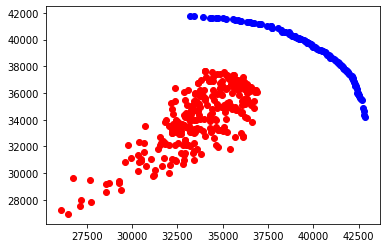

taille du front efficace
(287, 100)
0.0%
0.5617977528089888%
1.1235955056179776%
1.6853932584269662%
2.247191011235955%
2.8089887640449436%
3.3707865168539324%
3.932584269662921%
4.49438202247191%
5.056179775280898%
5.617977528089887%
6.179775280898876%
6.741573033707865%
7.303370786516854%
7.865168539325842%
8.426966292134832%
8.98876404494382%
9.550561797752808%
10.112359550561797%
10.674157303370785%
11.235955056179774%
11.797752808988763%
12.359550561797752%
12.921348314606742%
13.48314606741573%
14.04494382022472%
14.606741573033707%
15.168539325842698%
15.730337078651685%
16.292134831460675%
16.853932584269664%
17.415730337078653%
17.97752808988764%
18.53932584269663%
19.101123595505616%
19.662921348314608%
20.224719101123593%
20.786516853932586%
21.34831460674157%
21.910112359550563%
22.47191011235955%
23.03370786516854%
23.595505617977526%
24.15730337078652%
24.719101123595504%
25.280898876404496%
25.842696629213485%
26.40449438202247%
26.96629213483146%
27.52808988764045%
28.0

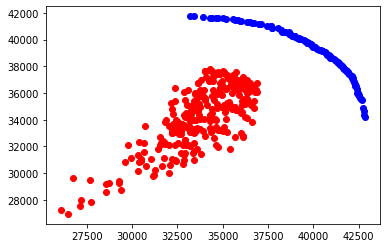

taille du front efficace
(302, 100)
0.0%
0.53475935828877%
1.06951871657754%
1.6042780748663104%
2.13903743315508%
2.6737967914438503%
3.2085561497326207%
3.7433155080213902%
4.27807486631016%
4.81283422459893%
5.347593582887701%
5.88235294117647%
6.417112299465241%
6.951871657754011%
7.4866310160427805%
8.02139037433155%
8.55614973262032%
9.090909090909092%
9.62566844919786%
10.16042780748663%
10.695187165775401%
11.229946524064172%
11.76470588235294%
12.299465240641712%
12.834224598930483%
13.368983957219251%
13.903743315508022%
14.43850267379679%
14.973262032085561%
15.508021390374333%
16.0427807486631%
16.577540106951872%
17.11229946524064%
17.647058823529413%
18.181818181818183%
18.71657754010695%
19.25133689839572%
19.786096256684495%
20.32085561497326%
20.855614973262032%
21.390374331550802%
21.92513368983957%
22.459893048128343%
22.994652406417114%
23.52941176470588%
24.06417112299465%
24.598930481283425%
25.13368983957219%
25.668449197860966%
26.203208556149733%
26.73796791443

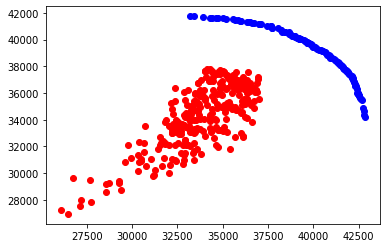

taille du front efficace
(309, 100)
0.0%
0.684931506849315%
1.36986301369863%
2.054794520547945%
2.73972602739726%
3.4246575342465753%
4.10958904109589%
4.794520547945205%
5.47945205479452%
6.164383561643835%
6.8493150684931505%
7.534246575342466%
8.21917808219178%
8.904109589041095%
9.58904109589041%
10.273972602739725%
10.95890410958904%
11.643835616438356%
12.32876712328767%
13.013698630136986%
13.698630136986301%
14.383561643835616%
15.068493150684931%
15.753424657534246%
16.43835616438356%
17.123287671232877%
17.80821917808219%
18.493150684931507%
19.17808219178082%
19.863013698630137%
20.54794520547945%
21.232876712328768%
21.91780821917808%
22.602739726027394%
23.28767123287671%
23.972602739726025%
24.65753424657534%
25.34246575342466%
26.027397260273972%
26.71232876712329%
27.397260273972602%
28.08219178082192%
28.767123287671232%
29.45205479452055%
30.136986301369863%
30.82191780821918%
31.506849315068493%
32.19178082191781%
32.87671232876712%
33.56164383561644%
34.24657534246

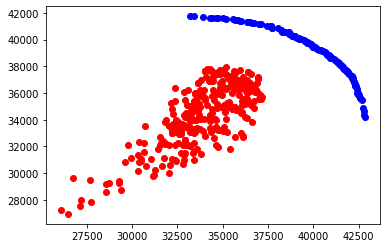

taille du front efficace
(320, 100)
0.0%
0.5780346820809248%
1.1560693641618496%
1.7341040462427744%
2.312138728323699%
2.8901734104046244%
3.4682080924855487%
4.046242774566474%
4.624277456647398%
5.202312138728324%
5.780346820809249%
6.358381502890173%
6.9364161849710975%
7.514450867052023%
8.092485549132949%
8.670520231213873%
9.248554913294797%
9.826589595375722%
10.404624277456648%
10.982658959537572%
11.560693641618498%
12.138728323699421%
12.716763005780345%
13.294797687861271%
13.872832369942195%
14.450867052023122%
15.028901734104046%
15.606936416184972%
16.184971098265898%
16.76300578034682%
17.341040462427745%
17.91907514450867%
18.497109826589593%
19.07514450867052%
19.653179190751445%
20.23121387283237%
20.809248554913296%
21.38728323699422%
21.965317919075144%
22.54335260115607%
23.121387283236995%
23.699421965317917%
24.277456647398843%
24.85549132947977%
25.43352601156069%
26.011560693641616%
26.589595375722542%
27.167630057803464%
27.74566473988439%
28.32369942196532%


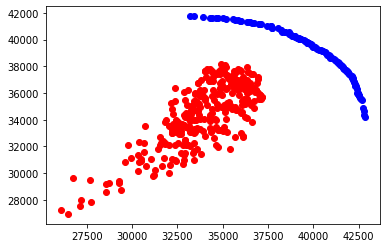

taille du front efficace
(330, 100)
0.0%
0.5076142131979695%
1.015228426395939%
1.5228426395939088%
2.030456852791878%
2.5380710659898478%
3.0456852791878175%
3.5532994923857872%
4.060913705583756%
4.568527918781726%
5.0761421319796955%
5.583756345177665%
6.091370558375635%
6.598984771573605%
7.1065989847715745%
7.614213197969544%
8.121827411167512%
8.629441624365482%
9.137055837563452%
9.644670050761421%
10.152284263959391%
10.65989847715736%
11.16751269035533%
11.6751269035533%
12.18274111675127%
12.690355329949238%
13.19796954314721%
13.705583756345177%
14.213197969543149%
14.720812182741117%
15.228426395939088%
15.736040609137056%
16.243654822335024%
16.751269035532996%
17.258883248730964%
17.766497461928935%
18.274111675126903%
18.781725888324875%
19.289340101522843%
19.796954314720814%
20.304568527918782%
20.812182741116754%
21.31979695431472%
21.82741116751269%
22.33502538071066%
22.84263959390863%
23.3502538071066%
23.85786802030457%
24.36548223350254%
24.873096446700508%
25.38

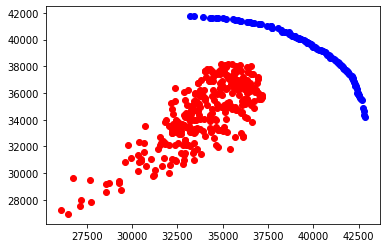

taille du front efficace
(341, 100)
0.0%
0.48543689320388345%
0.9708737864077669%
1.4563106796116505%
1.9417475728155338%
2.4271844660194173%
2.912621359223301%
3.3980582524271843%
3.8834951456310676%
4.368932038834951%
4.854368932038835%
5.339805825242718%
5.825242718446602%
6.310679611650485%
6.796116504854369%
7.281553398058252%
7.766990291262135%
8.25242718446602%
8.737864077669903%
9.223300970873787%
9.70873786407767%
10.194174757281553%
10.679611650485436%
11.165048543689322%
11.650485436893204%
12.135922330097088%
12.62135922330097%
13.106796116504855%
13.592233009708737%
14.077669902912621%
14.563106796116504%
15.048543689320388%
15.53398058252427%
16.019417475728158%
16.50485436893204%
16.990291262135923%
17.475728155339805%
17.96116504854369%
18.446601941747574%
18.932038834951456%
19.41747572815534%
19.902912621359224%
20.388349514563107%
20.87378640776699%
21.35922330097087%
21.844660194174757%
22.330097087378643%
22.815533980582526%
23.300970873786408%
23.78640776699029%
2

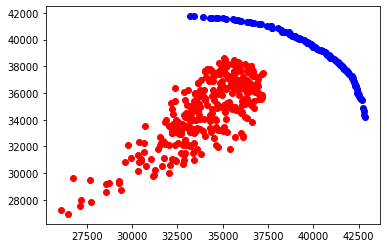

taille du front efficace
(368, 100)
0.0%
0.45045045045045046%
0.9009009009009009%
1.3513513513513513%
1.8018018018018018%
2.2522522522522523%
2.7027027027027026%
3.153153153153153%
3.6036036036036037%
4.054054054054054%
4.504504504504505%
4.954954954954955%
5.405405405405405%
5.8558558558558556%
6.306306306306306%
6.756756756756757%
7.207207207207207%
7.657657657657657%
8.108108108108109%
8.558558558558559%
9.00900900900901%
9.45945945945946%
9.90990990990991%
10.36036036036036%
10.81081081081081%
11.26126126126126%
11.711711711711711%
12.162162162162163%
12.612612612612612%
13.063063063063062%
13.513513513513514%
13.963963963963963%
14.414414414414415%
14.864864864864865%
15.315315315315313%
15.765765765765765%
16.216216216216218%
16.666666666666664%
17.117117117117118%
17.56756756756757%
18.01801801801802%
18.46846846846847%
18.91891891891892%
19.36936936936937%
19.81981981981982%
20.27027027027027%
20.72072072072072%
21.17117117117117%
21.62162162162162%
22.07207207207207%
22.522522

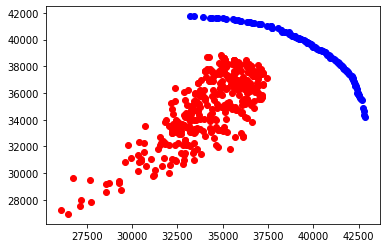

taille du front efficace
(398, 100)
0.0%
0.4444444444444444%
0.8888888888888888%
1.3333333333333335%
1.7777777777777777%
2.2222222222222223%
2.666666666666667%
3.111111111111111%
3.5555555555555554%
4.0%
4.444444444444445%
4.888888888888889%
5.333333333333334%
5.777777777777778%
6.222222222222222%
6.666666666666667%
7.111111111111111%
7.555555555555555%
8.0%
8.444444444444445%
8.88888888888889%
9.333333333333334%
9.777777777777779%
10.222222222222223%
10.666666666666668%
11.11111111111111%
11.555555555555555%
12.0%
12.444444444444445%
12.88888888888889%
13.333333333333334%
13.777777777777779%
14.222222222222221%
14.666666666666666%
15.11111111111111%
15.555555555555555%
16.0%
16.444444444444446%
16.88888888888889%
17.333333333333336%
17.77777777777778%
18.22222222222222%
18.666666666666668%
19.11111111111111%
19.555555555555557%
20.0%
20.444444444444446%
20.88888888888889%
21.333333333333336%
21.777777777777775%
22.22222222222222%
22.666666666666664%
23.11111111111111%
23.5555555555555

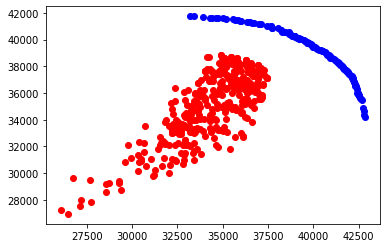

taille du front efficace
(425, 100)
0.0%
0.4329004329004329%
0.8658008658008658%
1.2987012987012987%
1.7316017316017316%
2.1645021645021645%
2.5974025974025974%
3.0303030303030303%
3.463203463203463%
3.896103896103896%
4.329004329004329%
4.761904761904762%
5.194805194805195%
5.627705627705628%
6.0606060606060606%
6.493506493506493%
6.926406926406926%
7.35930735930736%
7.792207792207792%
8.225108225108226%
8.658008658008658%
9.090909090909092%
9.523809523809524%
9.956709956709958%
10.38961038961039%
10.822510822510822%
11.255411255411255%
11.688311688311687%
12.121212121212121%
12.554112554112553%
12.987012987012985%
13.41991341991342%
13.852813852813853%
14.285714285714285%
14.71861471861472%
15.151515151515152%
15.584415584415584%
16.017316017316016%
16.450216450216452%
16.883116883116884%
17.316017316017316%
17.74891774891775%
18.181818181818183%
18.614718614718615%
19.047619047619047%
19.480519480519483%
19.913419913419915%
20.346320346320347%
20.77922077922078%
21.21212121212121%
2

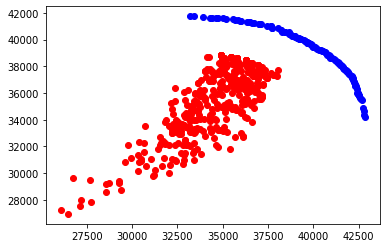

taille du front efficace
(464, 100)
0.0%
0.4329004329004329%
0.8658008658008658%
1.2987012987012987%
1.7316017316017316%
2.1645021645021645%
2.5974025974025974%
3.0303030303030303%
3.463203463203463%
3.896103896103896%
4.329004329004329%
4.761904761904762%
5.194805194805195%
5.627705627705628%
6.0606060606060606%
6.493506493506493%
6.926406926406926%
7.35930735930736%
7.792207792207792%
8.225108225108226%
8.658008658008658%
9.090909090909092%
9.523809523809524%
9.956709956709958%
10.38961038961039%
10.822510822510822%
11.255411255411255%
11.688311688311687%
12.121212121212121%
12.554112554112553%
12.987012987012985%
13.41991341991342%
13.852813852813853%
14.285714285714285%
14.71861471861472%
15.151515151515152%
15.584415584415584%
16.017316017316016%
16.450216450216452%
16.883116883116884%
17.316017316017316%
17.74891774891775%
18.181818181818183%
18.614718614718615%
19.047619047619047%
19.480519480519483%
19.913419913419915%
20.346320346320347%
20.77922077922078%
21.21212121212121%
2

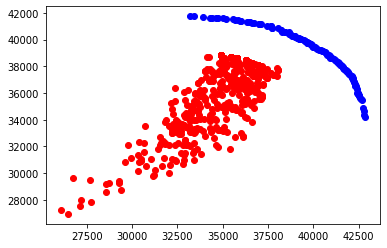

taille du front efficace
(510, 100)
0.0%
0.32573289902280134%
0.6514657980456027%
0.9771986970684038%
1.3029315960912053%
1.6286644951140066%
1.9543973941368076%
2.2801302931596092%
2.6058631921824107%
2.9315960912052117%
3.257328990228013%
3.5830618892508146%
3.908794788273615%
4.234527687296417%
4.5602605863192185%
4.88599348534202%
5.211726384364821%
5.537459283387622%
5.863192182410423%
6.188925081433225%
6.514657980456026%
6.840390879478828%
7.166123778501629%
7.491856677524431%
7.81758957654723%
8.143322475570033%
8.469055374592834%
8.794788273615636%
9.120521172638437%
9.446254071661238%
9.77198697068404%
10.097719869706841%
10.423452768729643%
10.749185667752444%
11.074918566775244%
11.400651465798045%
11.726384364820847%
12.052117263843648%
12.37785016286645%
12.703583061889251%
13.029315960912053%
13.355048859934854%
13.680781758957655%
14.006514657980457%
14.332247557003258%
14.65798045602606%
14.983713355048861%
15.309446254071663%
15.63517915309446%
15.960912052117262%
16.

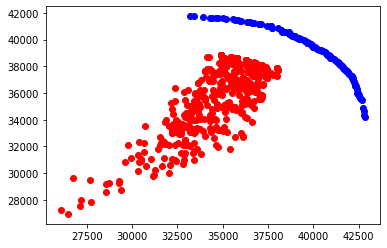

taille du front efficace
(569, 100)
0.0%
0.3215434083601286%
0.6430868167202572%
0.964630225080386%
1.2861736334405145%
1.607717041800643%
1.929260450160772%
2.2508038585209005%
2.572347266881029%
2.8938906752411575%
3.215434083601286%
3.536977491961415%
3.858520900321544%
4.180064308681672%
4.501607717041801%
4.823151125401929%
5.144694533762058%
5.466237942122187%
5.787781350482315%
6.109324758842444%
6.430868167202572%
6.752411575562702%
7.07395498392283%
7.395498392282958%
7.717041800643088%
8.038585209003216%
8.360128617363344%
8.681672025723474%
9.003215434083602%
9.32475884244373%
9.646302250803858%
9.967845659163988%
10.289389067524116%
10.610932475884244%
10.932475884244374%
11.254019292604502%
11.57556270096463%
11.89710610932476%
12.218649517684888%
12.540192926045016%
12.861736334405144%
13.183279742765272%
13.504823151125404%
13.826366559485532%
14.14790996784566%
14.469453376205788%
14.790996784565916%
15.112540192926044%
15.434083601286176%
15.755627009646304%
16.0771704

In [ ]:
localParetoSearchNew(objects, weight, nd_points)